In [1]:
%pylab inline
import mxnet as mx
import numpy as np
import cv2
# Install this utility package from pip using 'pip install cvutils'
import cvutils
from skimage import io, transform

Populating the interactive namespace from numpy and matplotlib


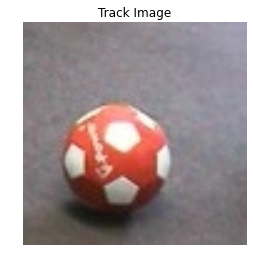

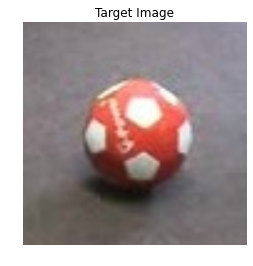

In [2]:
# Load the images
im_image = cv2.imread("./image.jpg")
im_target = cv2.imread("./target.jpg")
# Display the images
cvutils.imshow("Track Image", im_image)
cvutils.imshow("Target Image", im_target)

('Original Image Shape: ', (90, 90, 3))
('Processed Image Shape: ', (3, 227, 227))
('Original Image Shape: ', (90, 90, 3))
('Processed Image Shape: ', (3, 227, 227))


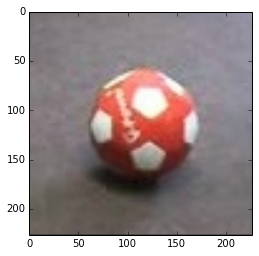

In [3]:
width = 227
height = 227
def PreprocessImage(path, show_img=True):
    # load image
    img = io.imread(path)
    print("Original Image Shape: ", img.shape)
    # we crop image from center
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy : yy + short_egde, xx : xx + short_egde]

    resized_img = transform.resize(crop_img, (width, height))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256

    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    print ("Processed Image Shape: ", sample.shape)
    # sub mean
    normed_img = sample - 128.
    return np.reshape(normed_img, (1, 3, width, height))

# Get preprocessed batch (single image batch)
image = PreprocessImage('./image.jpg', True)
target = PreprocessImage('./target.jpg', True)

In [4]:
# load symbol and params
sym, arg_params, aux_params = mx.model.load_checkpoint("tracker", 1)

In [5]:
ctx=mx.gpu()
arg_params['target'] = mx.nd.array(target, ctx)
arg_params['image'] = mx.nd.array(image, ctx)

In [6]:
executor = sym.bind(ctx, arg_params, args_grad=None, grad_req='null', aux_states=aux_params)
executor.forward(is_train=False)

In [7]:
output_dict = {name: nd for name, nd in zip(sym.list_outputs(), executor.outputs)}
out = output_dict['fc8_shapes_output'].asnumpy()

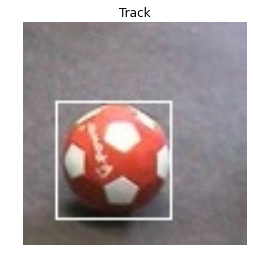

In [8]:
scalar = 10.0
shape = im_image.shape
top_left=((int)(out[0][0]/scalar*shape[0]+0.5), (int)(out[0][1]/scalar*shape[1]+0.5))
bottom_right=((int)(out[0][2]/scalar*shape[0]+0.5), (int)(out[0][3]/scalar*shape[1]+0.5))
im_display = im_image.copy()
cv2.rectangle(im_display, top_left, bottom_right, (255,255,255), 1)
cvutils.imshow("Track", im_display)